In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\slthi\Downloads\salesdata.csv", parse_dates=['DateKey','Invoice Date', 'Promised Delivery Date'])
df

,Custkey,DateKey,Discount Amount,Invoice Date,Invoice Number,Item Class,Item Number,Item,Line Number,List Price,Order Number,Promised Delivery Date,Sales Amount,Sales Amount Based on List Price,Sales Cost Amount,Sales Margin Amount,Sales Price,Sales Quantity,Sales Rep,U/M
0,10016609,2019-12-31,398.7300,2019-12-31,329568,P01,15640,Super Vegetable Oil,1000,163.4700,122380,2019-12-31,418.62,817.3500,102.99,315.63,83.72400,5,176,EA
1,10016609,2019-12-31,268.6700,2019-12-31,329569,P01,31681,Golden Fajita French Fries,7000,275.3700,123966,2019-12-31,282.07,550.7400,117.45,164.62,141.03500,2,176,EA
2,10016609,2019-12-31,398.7300,2019-12-31,329569,P01,15640,Super Vegetable Oil,4000,163.4700,123966,2019-12-31,418.62,817.3500,102.99,315.63,83.72400,5,176,EA
3,10016609,2019-12-31,466.4500,2019-12-31,329569,P01,13447,High Top Oranges,3000,119.5200,123966,2019-12-31,489.71,956.1600,213.29,276.42,61.21375,8,176,EA
4,10016609,2019-12-31,515.5100,2019-12-31,329569,P01,36942,Tell Tale New Potatos,9000,264.1800,123966,2019-12-31,541.21,1056.7200,290.56,250.65,135.30250,4,176,EA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65275,10025919,2017-01-01,466.3700,2017-01-01,119182,NaN,33503,Best Choice Graham Crackers,1000,1029.9800,216716,2017-01-01,563.61,1029.9800,312.93,250.68,563.61000,1,108,EA
65276,10009985,2017-01-01,783.9700,2017-01-01,119186,P01,47801,Red Spade Foot-Long Hot Dogs,1000,1627.8400,216728,2017-01-01,843.87,1627.8400,475.75,368.12,843.87000,1,173,EA
65277,10025552,2017-01-01,1309.5297,2017-01-01,119192,P01,37441,Atomic Mint Chocolate Bar,1000,1254.1899,216740,2017-01-01,2453.04,3762.5697,1032.83,1420.21,817.68000,3,180,EA
65278,10025025,2017-01-01,222.6500,2017-01-01,119197,P01,30093,Just Right Canned Tuna in Water,1000,491.7200,216761,2017-01-01,269.07,491.7200,159.14,109.93,269.07000,1,143,EA


In [4]:
df.shape

(65280, 20)

In [5]:
df.columns

Index(['Custkey', 'DateKey', 'Discount Amount', 'Invoice Date',
       'Invoice Number', 'Item Class', 'Item Number', 'Item', 'Line Number',
       'List Price', 'Order Number', 'Promised Delivery Date', 'Sales Amount',
       'Sales Amount Based on List Price', 'Sales Cost Amount',
       'Sales Margin Amount', 'Sales Price', 'Sales Quantity', 'Sales Rep',
       'U/M'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65280 entries, 0 to 65279
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Custkey                           65280 non-null  int64         
 1   DateKey                           65280 non-null  datetime64[ns]
 2   Discount Amount                   65278 non-null  float64       
 3   Invoice Date                      65280 non-null  datetime64[ns]
 4   Invoice Number                    65280 non-null  int64         
 5   Item Class                        56995 non-null  object        
 6   Item Number                       65240 non-null  object        
 7   Item                              65280 non-null  object        
 8   Line Number                       65280 non-null  int64         
 9   List Price                        65280 non-null  float64       
 10  Order Number                      65280 non-nu

In [7]:
df.isnull().sum()

Custkey                                0
DateKey                                0
Discount Amount                        2
Invoice Date                           0
Invoice Number                         0
Item Class                          8285
Item Number                           40
Item                                   0
Line Number                            0
List Price                             0
Order Number                           0
Promised Delivery Date                 0
Sales Amount                           0
Sales Amount Based on List Price       0
Sales Cost Amount                      0
Sales Margin Amount                    0
Sales Price                            1
Sales Quantity                         0
Sales Rep                              0
U/M                                    0
dtype: int64

In [8]:
df1 = df.copy()

In [9]:
df1['Item Class'].value_counts()

Item Class
P01    56965
PO1       16
P02        1
P12        1
P13        1
P06        1
P15        1
P11        1
P08        1
P07        1
P10        1
P09        1
P14        1
P03        1
P05        1
P04        1
Name: count, dtype: int64

In [10]:
df1.dropna(subset=['Discount Amount','Sales Price', 'Item Number'],inplace=True)

In [11]:
df1.describe()

,Custkey,DateKey,Discount Amount,Invoice Date,Invoice Number,Line Number,List Price,Order Number,Promised Delivery Date,Sales Amount,Sales Amount Based on List Price,Sales Cost Amount,Sales Margin Amount,Sales Price,Sales Quantity,Sales Rep
count,6.524000e+04,65240,65240.000000,65240,65240.000000,65240.000000,65240.000000,65240.000000,65240,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000
mean,1.001770e+07,2018-06-11 17:57:26.376456192,1857.332863,2018-06-11 17:57:26.376456192,216294.567259,23725.376180,515.021356,180567.311695,2018-06-09 02:41:55.364806912,2853.161197,4710.494059,1662.048528,1191.112669,283.253429,45.107357,137.421735
min,1.000045e+07,2017-01-01 00:00:00,-255820.800000,2017-01-01 00:00:00,100080.000000,1000.000000,0.000000,100838.000000,2008-12-15 00:00:00,200.010000,0.000000,0.000000,-3932.930000,0.337341,1.000000,103.000000
25%,1.001272e+07,2017-07-24 00:00:00,246.280000,2017-07-24 00:00:00,117969.750000,3000.000000,181.560000,115281.000000,2017-07-23 00:00:00,308.362500,561.040000,167.810000,129.890000,100.030000,2.000000,113.000000
50%,1.001966e+07,2018-01-29 00:00:00,442.205000,2018-01-29 00:00:00,222906.000000,12000.000000,325.190000,203695.000000,2018-01-29 00:00:00,553.940000,999.750000,304.580000,246.480000,183.283929,3.000000,134.000000
75%,1.002351e+07,2019-06-17 00:00:00,1001.500000,2019-06-17 00:00:00,314325.000000,32000.000000,803.860000,218576.000000,2019-06-17 00:00:00,1279.752500,2321.400000,688.550000,578.220000,448.220000,8.000000,160.000000
max,1.002758e+07,2019-12-31 00:00:00,343532.660000,2019-12-31 00:00:00,332842.000000,344000.000000,2760.700000,321532.000000,2019-12-31 00:00:00,555376.000000,632610.160000,366576.000000,188800.000000,6035.000000,16000.000000,185.000000
std,7.175892e+03,NaN,9039.603327,NaN,94981.656013,32669.704672,449.146853,67612.713894,NaN,15169.133687,20702.762126,9559.467966,5862.610381,250.449245,429.796995,26.644355


In [12]:
# Creating Year, Month, Quarter, Day Columns in Sales_data01
df1['Invoice_Year'] = df['Invoice Date'].dt.year
df1['Invoice_Month'] = df['Invoice Date'].dt.month
df1['Invoice_Quarter'] = df['Invoice Date'].dt.quarter
df1['Invoice_Day'] = df['Invoice Date'].dt.day

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65240 entries, 0 to 65279
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Custkey                           65240 non-null  int64         
 1   DateKey                           65240 non-null  datetime64[ns]
 2   Discount Amount                   65240 non-null  float64       
 3   Invoice Date                      65240 non-null  datetime64[ns]
 4   Invoice Number                    65240 non-null  int64         
 5   Item Class                        56993 non-null  object        
 6   Item Number                       65240 non-null  object        
 7   Item                              65240 non-null  object        
 8   Line Number                       65240 non-null  int64         
 9   List Price                        65240 non-null  float64       
 10  Order Number                      65240 non-null  i

In [14]:
print(df1.columns.tolist())

['Custkey', 'DateKey', 'Discount Amount', 'Invoice Date', 'Invoice Number', 'Item Class', 'Item Number', 'Item', 'Line Number', 'List Price', 'Order Number', 'Promised Delivery Date', 'Sales Amount', 'Sales Amount Based on List Price', 'Sales Cost Amount', 'Sales Margin Amount', 'Sales Price', 'Sales Quantity', 'Sales Rep', 'U/M', 'Invoice_Year', 'Invoice_Month', 'Invoice_Quarter', 'Invoice_Day']


In [15]:
df2 = df1[['Custkey','Item','Invoice Date','Invoice_Year','Invoice_Quarter', 'Invoice_Month',
                           'Invoice_Day', 'Sales Quantity', 'Sales Amount Based on List Price','Discount Amount',
                           'Sales Amount', 'Sales Margin Amount','Sales Cost Amount','Sales Rep','U/M','List Price',
                           'Sales Price']]

In [16]:
df2.isnull().sum()

Custkey                             0
Item                                0
Invoice Date                        0
Invoice_Year                        0
Invoice_Quarter                     0
Invoice_Month                       0
Invoice_Day                         0
Sales Quantity                      0
Sales Amount Based on List Price    0
Discount Amount                     0
Sales Amount                        0
Sales Margin Amount                 0
Sales Cost Amount                   0
Sales Rep                           0
U/M                                 0
List Price                          0
Sales Price                         0
dtype: int64

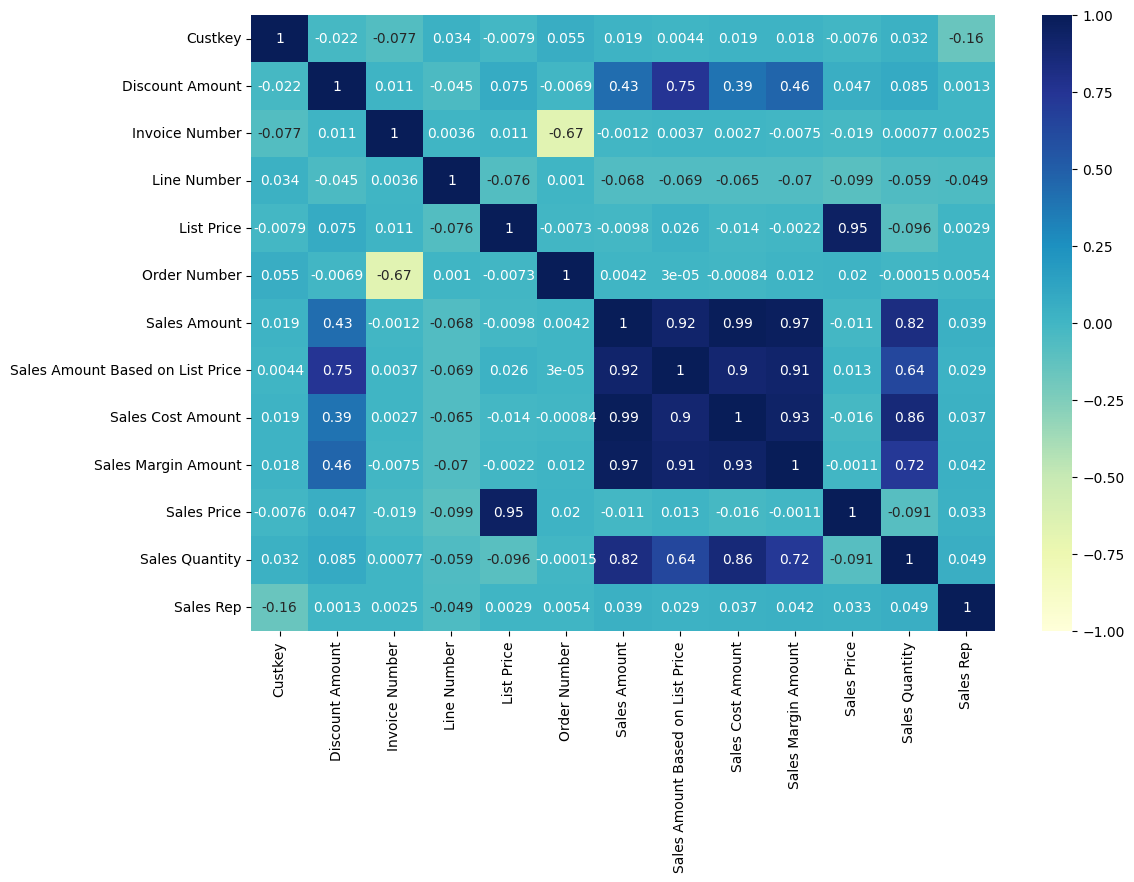

In [17]:
plt.figure(figsize=(12,8))

# Selecting only numeric columns
numeric_df = df.select_dtypes(include=['number'])

sns.heatmap(numeric_df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap='YlGnBu')

plt.show()

Observations:

1 Discount Amount is highly related to Sales Amount, Sales Cost Amount, Sales Amount Based on List Price & Sales Margin Amount and moderately related to Sales Quantity.

2- List Price highly related to sales price and has no relations with Sales amount, Sales cost amount, Sales amount based on list price & sales margin amount.

3- Sales quantity is moderately related to Sales amount, discount amount, sales margin amount.
Their is no relation Between Sales Rep and Sales Amount, Sales Margin Amount.


In [18]:
sns.set(style = 'darkgrid')

# Top 10 high sales day

In [19]:
DaySalesInsights = df1.copy()
DaySalesInsights['Invoice_Date'] = pd.to_datetime(df1['Invoice Date']).dt.date

In [20]:
top10sales = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Amount': 'sum'})  # Specify only numeric columns
    .sort_values('Sales Amount', ascending=False)
    .reset_index()
    .head(10)
)


C:\Users\slthi\AppData\Local\Temp\ipykernel_11144\2371591217.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(y = 'Sales Amount', x = 'Invoice_Date', data = top10sales, aspect = 2,palette='turbo',kind="bar")


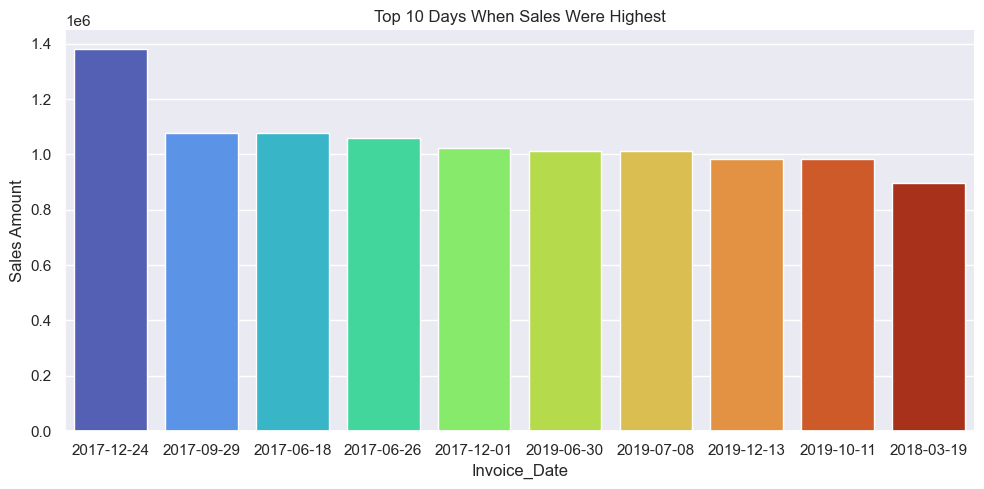

In [21]:
sns.catplot(y = 'Sales Amount', x = 'Invoice_Date', data = top10sales, aspect = 2,palette='turbo',kind="bar")
plt.title('Top 10 Days When Sales Were Highest')
top10sales[['Sales Amount']]
plt.show()

# Top 10 high profit dates

In [22]:
top10profits = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Margin Amount': 'sum'})  # Aggregate only the required column
    .sort_values('Sales Margin Amount', ascending=False)
    .reset_index()
    .head(10)
)

C:\Users\slthi\AppData\Local\Temp\ipykernel_11144\1805149753.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(y = 'Sales Margin Amount', x = 'Invoice_Date', data = top10profits, aspect = 2,palette='turbo',kind="bar")


,Sales Margin Amount
0,619085.33
1,480769.87
2,477173.34
3,450965.94
4,436621.64
5,413530.29
6,406118.86
7,398430.22
8,398222.72
9,392326.13


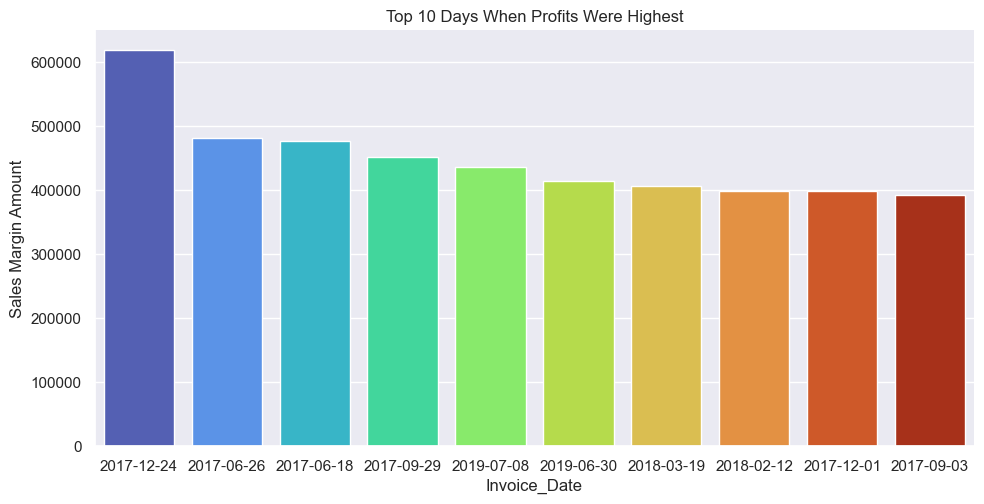

In [23]:
sns.catplot(y = 'Sales Margin Amount', x = 'Invoice_Date', data = top10profits, aspect = 2,palette='turbo',kind="bar")
plt.title('Top 10 Days When Profits Were Highest')
top10profits[['Sales Margin Amount']]

# Top 10 highest quantity sales

In [24]:
highqty = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Quantity': 'sum'})  # Sum only 'Sales Quantity'
    .sort_values('Sales Quantity', ascending=False)
    .reset_index()
    .head(10)
)


C:\Users\slthi\AppData\Local\Temp\ipykernel_11144\783720503.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(y = 'Sales Quantity', x = 'Invoice_Date', data = highqty, aspect = 2,palette='turbo',kind="bar")


,Sales Quantity
0,23710
1,23708
2,17822
3,17820
4,17819
5,17819
6,17819
7,17819
8,17819
9,17649


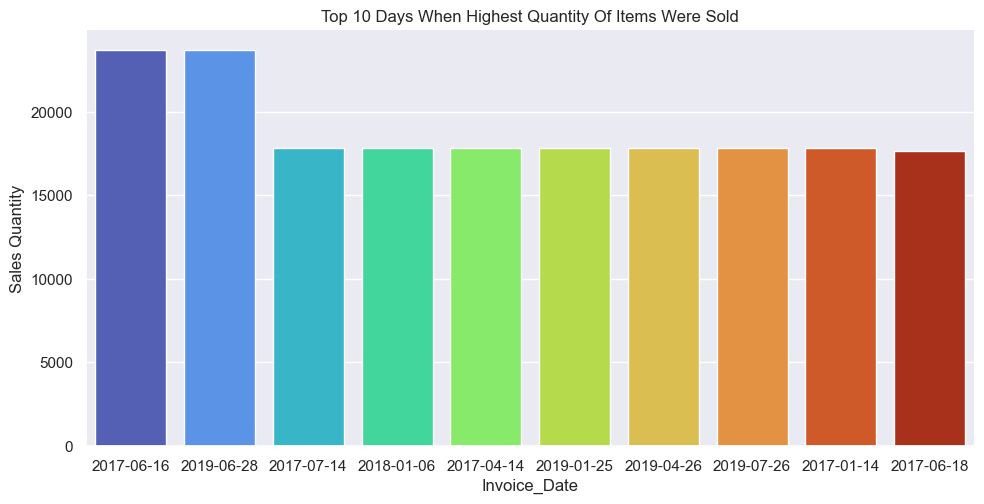

In [25]:
sns.catplot(y = 'Sales Quantity', x = 'Invoice_Date', data = highqty, aspect = 2,palette='turbo',kind="bar")
plt.title('Top 10 Days When Highest Quantity Of Items Were Sold')
highqty[['Sales Quantity']]

# Top 10 days with most customers

In [26]:
MostCust = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Custkey': 'count'})  # Count the number of customers per Invoice_Date
    .sort_values('Custkey', ascending=False)
    .reset_index()
    .head(10)
)


C:\Users\slthi\AppData\Local\Temp\ipykernel_11144\958402252.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(y = 'Custkey', x = 'Invoice_Date', data = MostCust, aspect = 2,palette='turbo',kind="bar")


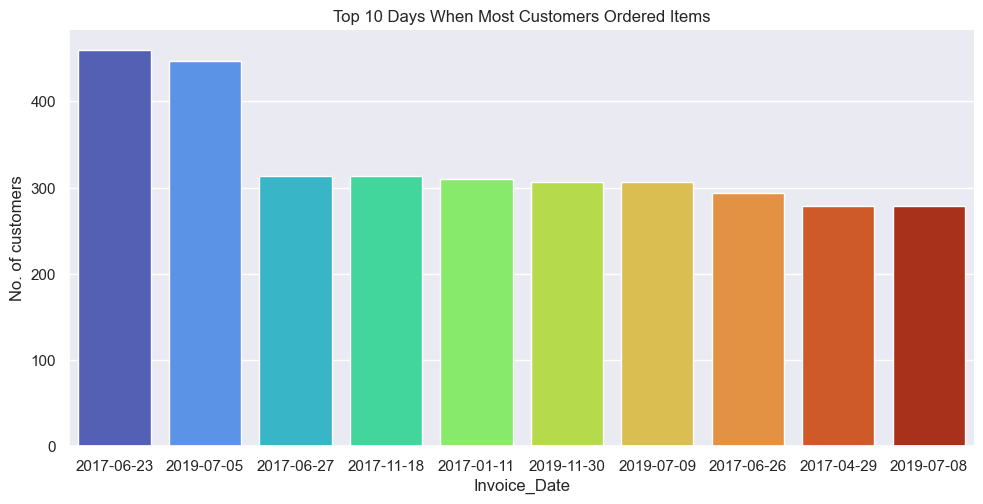

In [27]:
sns.catplot(y = 'Custkey', x = 'Invoice_Date', data = MostCust, aspect = 2,palette='turbo',kind="bar")
plt.title('Top 10 Days When Most Customers Ordered Items')
plt.ylabel('No. of customers')
plt.show()